# Linear Autoencoder

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [66]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=True, transform=transform)
validset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=False, transform=transform)

batch_size = 20

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

### Model

In [105]:
class LinearAutoencoder(nn.Module):
    def __init__(self, compress_dim):
        super(LinearAutoencoder, self).__init__()
        ## Encoder ##
        self.fc1e = nn.Linear(28*28, 256)
        self.fc2e = nn.Linear(256, compress_dim)
        
        ## Decoder ##
        self.fc2d = nn.Linear(compress_dim, 256)
        self.fc1d = nn.Linear(256, 28*28)
        
        ## Dropout ##
        self.dropout = nn.Dropout(p=0.0)
        
    def forward(self, x):        
        x = self.dropout(F.relu(self.fc1e(x)))
        x = self.dropout(F.relu(self.fc2e(x)))
        
        x = self.dropout(F.relu(self.fc2d(x)))
        x = torch.sigmoid(self.fc1d(x))
        
        return x

model = LinearAutoencoder(compress_dim=16)
print(model)


LinearAutoencoder(
  (fc1e): Linear(in_features=784, out_features=256, bias=True)
  (fc2e): Linear(in_features=256, out_features=16, bias=True)
  (fc2d): Linear(in_features=16, out_features=256, bias=True)
  (fc1d): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


### Loss function and optimizer

In [106]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train model

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 20
for iepoch in range(n_epochs):
    batch_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item() * images.shape[0]
    epoch_loss = batch_loss / len(trainloader)
    print('Epoch: {} ... Train loss: {:0.6f}'.format(iepoch+1, epoch_loss))

Epoch: 1 ... Train loss: 0.563802
Epoch: 2 ... Train loss: 0.395084
Epoch: 3 ... Train loss: 0.361094
Epoch: 4 ... Train loss: 0.343416
Epoch: 5 ... Train loss: 0.323920
Epoch: 6 ... Train loss: 0.307120
Epoch: 7 ... Train loss: 0.298725
Epoch: 8 ... Train loss: 0.292499
Epoch: 9 ... Train loss: 0.287369
Epoch: 10 ... Train loss: 0.283562
Epoch: 11 ... Train loss: 0.280138
Epoch: 12 ... Train loss: 0.277178
Epoch: 13 ... Train loss: 0.274705
Epoch: 14 ... Train loss: 0.272498
Epoch: 15 ... Train loss: 0.270538
Epoch: 16 ... Train loss: 0.268640
Epoch: 17 ... Train loss: 0.266845
Epoch: 18 ... Train loss: 0.265570
Epoch: 19 ... Train loss: 0.264235
Epoch: 20 ... Train loss: 0.262907


### Visualize the performance

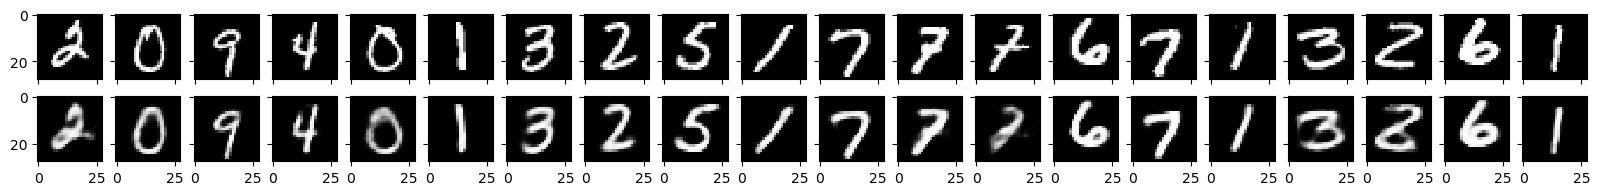

In [108]:
images, labels = next(iter(validloader))
images_flat = images.view(images.shape[0],-1)
images_flat = images_flat.to(device)
model.eval()
with torch.no_grad():
    output = model(images_flat)
output = output.view(output.shape[0], 1, 28, 28)

images = images.to('cpu').numpy()
output = output.to('cpu').numpy()

fig, ax = plt.subplots(2,images.shape[0], figsize=(images.shape[0],2), dpi=100, sharex=True, sharey=True)
for i in range(output.shape[0]):
    ax[0,i].imshow(images[i,0,:,:], cmap='gray')
    ax[1,i].imshow(output[i,0,:,:], cmap='gray')
plt.show()